# DATA SCIENTIST AT CLARITY AI
## PRACTICAL EXERCISE 
Practical exercise for a data scientist position at Clarity AI. The exercise consists of the business understanding, data preparation, model building, production plan, and storytelling from a binary classifier problem. 

The problem is about predicting the poverty of countries based on categorical and numerical data. The current data is encoded. Its original version was released by the World Bank in the context of **Pover-T Test: Prediction Poverty** competition.

The competition was motivated by the desire of the World Bank to end poverty by 2030 and its awareness of the value added by poverty prediction models along this process. Click [here](https://www.drivendata.org/competitions/50/worldbank-poverty-prediction/) for more info.

Let's get started!

# DATA EXPLORATION

# IMPORTS AND CLASSES

## COMMENTS
* Please, make sure to have XGBOOST installed

In [1]:
import copy
import itertools
import numpy as np
import pandas as pd
import seaborn as sb

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb


from sklearn.model_selection import cross_val_score


sb.set_context("talk")

In [2]:
class Xy:
    """
    Class to hold dataframe (train or test) and help 
    execute the pertinent operations of it 
    """
    
    def __init__(self, path=None):
        if path:            
            df = pd.read_csv(path)
            df = df.rename(columns={'Unnamed: 0': 'ID'})
            df = df.sort_values('ID').reset_index(drop=True)        
            self._df = df
        

    def resume(self):
        df = self.df()

        toprint = ''
       
        toprint += 'DATA FRAME:'
        toprint += '\n\n{}'.format(df)

        toprint += '\n\nMISSING VALUES:'
        toprint += '\n\n{}'.format(pd.DataFrame(df.isnull().sum()).T)

        toprint += '\n\nDESCRIBE:'
        toprint += '\n\n{}'.format(df.describe())     

        print(toprint)


    def df(self):
        return copy.deepcopy(self._df)
    
    
    def update(self, df):
        self._df = df
    
    
    def X_cat(self):
        df = self.df()
        df = df.select_dtypes(include=['object', 'uint8'])
        return df
    
  
    def X_num(self):
        df = self.df()
        df = df.select_dtypes(include=['float64', 'int64'])
        return df  

    
    def X(self):
        df = self.df().iloc[:,:-1]
        return df  

    
    def y(self):
        df = self.df().iloc[:,-1]
        return df  
    
    
    def _replace_nan_numeric(self, mean):
        X_num = self.X_num().fillna(mean)
        df = self.df()
        for col in X_num:
            df[co] = X_num[col]
            
        other = copy.deepcopy(self)
        other.update(df)
            
        return other    
    
    
    def _normalize_numeric(self, min_X_num, max_X_num):
        df = self.df()
        
        X_num = self.X_num()
        X_num = (X_num-min_X_num)/(max_X_num-min_X_num)
        for col in X_num:
            df[col] = X_num[col]            
            
        other = copy.deepcopy(self)
        other.update(df)
                
        return other 
    
    
    def _one_hot_encoding(self):
        df = self.df()
        X_cat = self.X_cat()
        dummies = pd.get_dummies(X_cat, dummy_na=True) 
        
        for col in dummies.columns:
            name, surname = col.split('_')
            if name in df.columns:
                del df[name]
        
        df = pd.concat([dummies, df], axis=1)
            
        other = copy.deepcopy(self)
        other.update(df)
            
        return other    
    
    
    def _remove_index_columns(self, columns):
        df = self.df()
        for column in columns:
            del df[column]
            
        other = copy.deepcopy(self)
        other.update(df)
            
        return other
        
        
    def _remove_outliers(self, number_of_sigmas, mean, std):    
        factor = number_of_sigmas
        df = self.df()
        X_num = self.X_num()
        for col in X_num:
            series = df[col]
            _mean = mean[col]
            _std = std[col]
            mask = (series <  factor*_std + _mean); series = series[mask]
            mask = (series > -factor*_std + _mean); series = series[mask]

            df = df.loc[series.index]

        other = copy.deepcopy(self)
        other.update(df)
            
        return other
    
    
    def _remove_collinearity(self, columns):
        return self._remove_index_columns(columns)

## DATA OVERVIEW

In [3]:
train = Xy('./dataset/Exercise_train (4) (2).csv')
train.resume()
print('\n\n>>>INFO<<<\n')
train.df().info()

DATA FRAME:

        ID     id kjkrfgld bpowgknt raksnhjf vwpsxrgk  omtioxzz  yfmzwkru  \
0        0  46107    Lsuai    WXYiE    DtMvg    XAmOF      21.0      -2.0   
1        2   9646    AfgYR    zPfZR    rXCdD    qNABl      12.0      -3.0   
2        4  16463    KfoTG    zPfZR    DtMvg    NdlDR      21.0      -4.0   
3        5  98438    Lsuai      NaN    DtMvg    bUhyU      12.0      -3.0   
4        7  96788    Lsuai    THHLT    DtMvg    vVbnO      12.0      -3.0   
...    ...    ...      ...      ...      ...      ...       ...       ...   
6557  8198  45288    Lsuai    mDadf    rXCdD    vVbnO      21.0      -3.0   
6558  8199  65081    KfoTG    THHLT      NaN    hmAUm      12.0      -4.0   
6559  8200  34370    qzGkS    zPfZR    DtMvg    bUhyU      12.0      -4.0   
6560  8201  12297      NaN    WXYiE    TKfyw    bUhyU      30.0      -2.0   
6561  8202  39832    qzGkS    THHLT    rXCdD    QRKWz      12.0      -2.0   

      tiwrsloh  weioazcf   poor  
0         -7.0     -14.5  Fa

### COMMENTS
* DATAFRAME
    * data has categorical and numerical features
    * data has 6562 rows and 11 columns
    * label (last column) is boolean and it is True if the country is poor and False otherwise
* MISSING VALUES
    * there are missing values
* DESCRIBE
    * The value 111 from feature **omtioxzz** and the value 1000 from the feature **yfmzwkru** are outliers (look at their standard deviation)

## NUMERICAL DATA

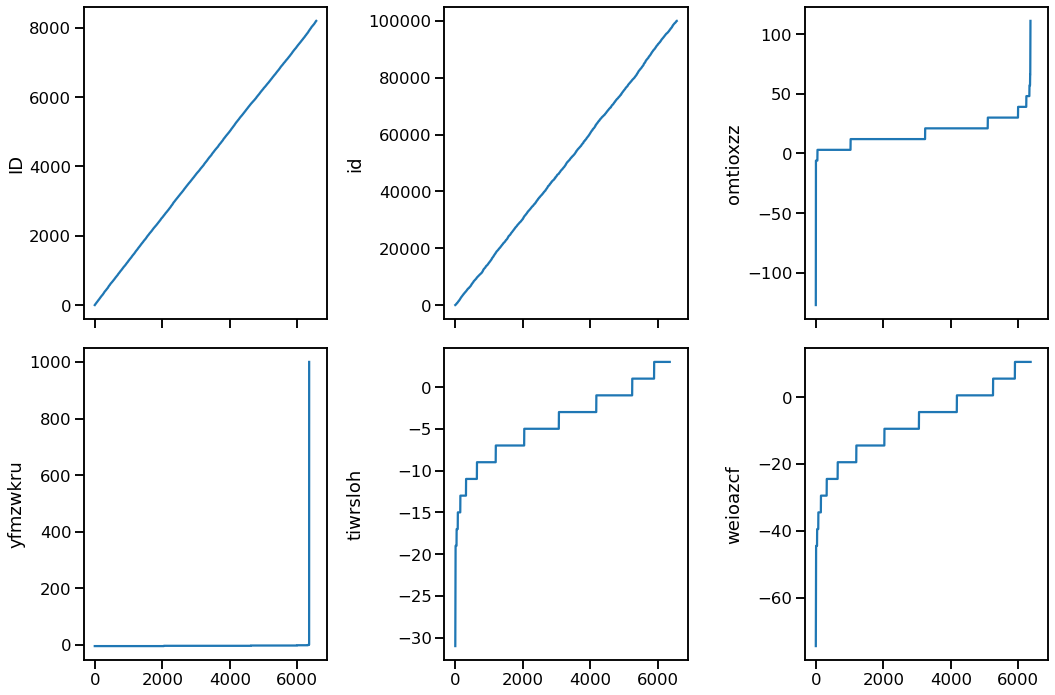

In [4]:
###
# - Verifyng index features (columns)
###

fig, axs = plt.subplots(int(len(train.X_num().columns)/3), 3, figsize=(15,10), sharex=True)
axs = [_ax for ax in axs for _ax in ax]

for col, ax in zip(train.X_num(), axs):
    sb.lineplot(x=range(len(train.df()[col])), y=train.df()[col].sort_values(), ax=ax)
fig.align_ylabels(); fig.tight_layout()

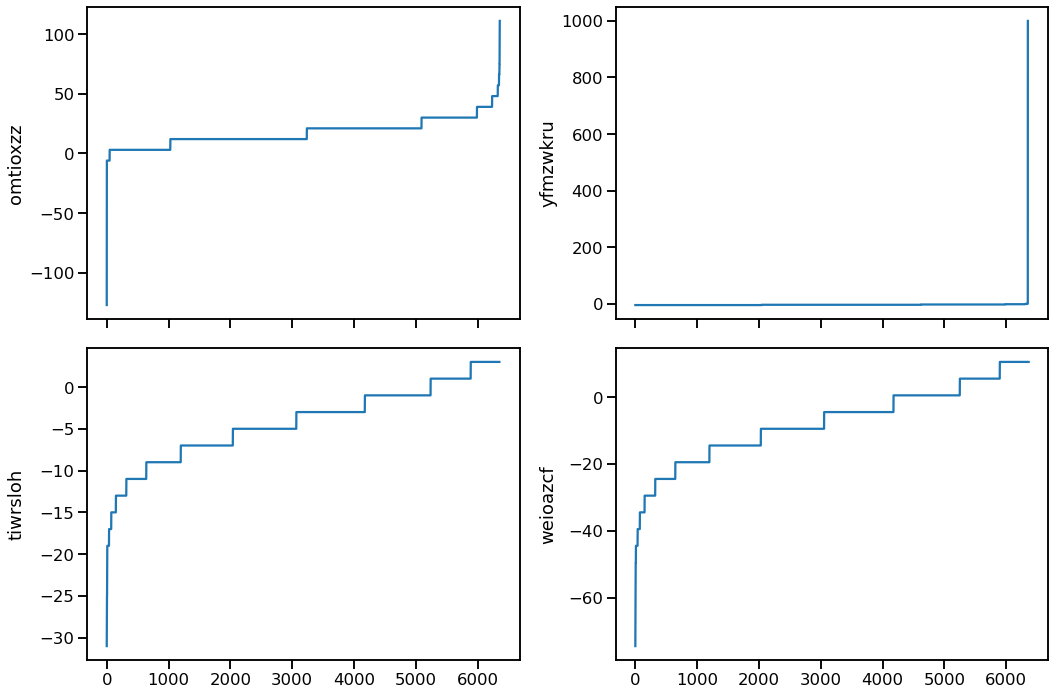

In [5]:
###
# - Features ID and id are indexes columns: let's remove them
###

other = train._remove_index_columns(['ID', 'id'])

fig, axs = plt.subplots(int(len(other.X_num().columns)/2), 2, figsize=(15,10), sharex=True)
axs = [_ax for ax in axs for _ax in ax]

for col, ax in zip(other.X_num(), axs):
    sb.lineplot(x=range(len(other.df()[col])), y=other.df()[col].sort_values(), ax=ax)
fig.align_ylabels(); fig.tight_layout()

In [6]:
train = other
train.resume()

DATA FRAME:

     kjkrfgld bpowgknt raksnhjf vwpsxrgk  omtioxzz  yfmzwkru  tiwrsloh  \
0       Lsuai    WXYiE    DtMvg    XAmOF      21.0      -2.0      -7.0   
1       AfgYR    zPfZR    rXCdD    qNABl      12.0      -3.0      -7.0   
2       KfoTG    zPfZR    DtMvg    NdlDR      21.0      -4.0      -5.0   
3       Lsuai      NaN    DtMvg    bUhyU      12.0      -3.0      -1.0   
4       Lsuai    THHLT    DtMvg    vVbnO      12.0      -3.0      -3.0   
...       ...      ...      ...      ...       ...       ...       ...   
6557    Lsuai    mDadf    rXCdD    vVbnO      21.0      -3.0      -3.0   
6558    KfoTG    THHLT      NaN    hmAUm      12.0      -4.0       3.0   
6559    qzGkS    zPfZR    DtMvg    bUhyU      12.0      -4.0       3.0   
6560      NaN    WXYiE    TKfyw    bUhyU      30.0      -2.0      -7.0   
6561    qzGkS    THHLT    rXCdD    QRKWz      12.0      -2.0      -1.0   

      weioazcf   poor  
0        -14.5  False  
1        -14.5   True  
2         -9.5   True  
3 

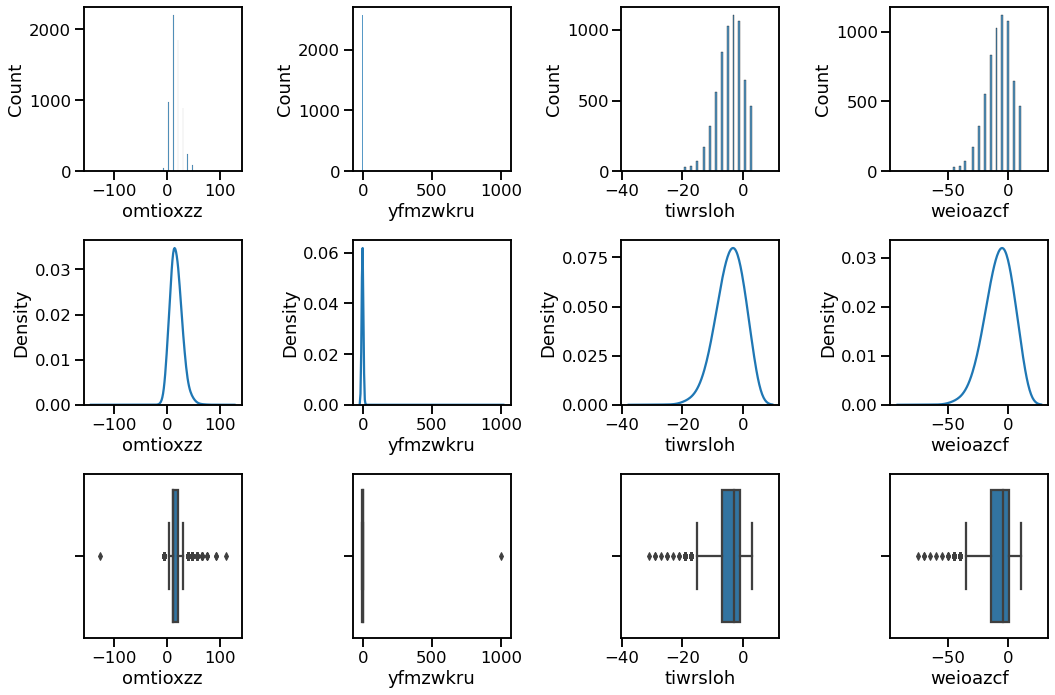

In [7]:
###
# - Checking for outliers
###

fig, axs = plt.subplots(3,4, figsize=(15, 10))
for enu, col in enumerate(train.X_num()):
    series = train.df()[col]
    sb.histplot(data=series,                ax=axs[0,enu])
    sb.kdeplot (data=series, bw_method=0.5, ax=axs[1,enu])
    sb.boxplot (x=series,                   ax=axs[2,enu])
    axs[0,enu].sharex(axs[1,enu]); axs[2,enu].sharex(axs[1,enu])
fig.tight_layout()

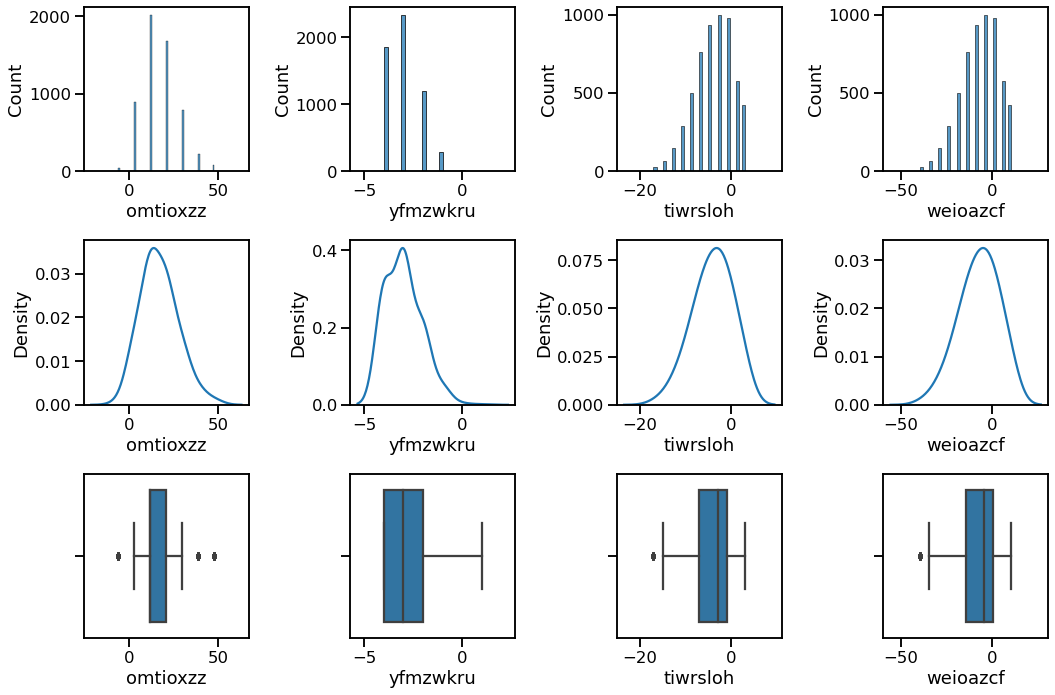

In [8]:
###
# - Removing outliers
# - In this process, the missing values from the numerical data
# - is also removed
# - These remotion could be avoided by applying some replacement technique (like the mean)
###

mean = train.X_num().mean()
std = train.X_num().std()
other = train._remove_outliers(3, mean, std)

fig, axs = plt.subplots(3,4, figsize=(15, 10))
for enu, col in enumerate(other.X_num()):
    series = other.df()[col]
    sb.histplot(data=series,                ax=axs[0,enu])
    sb.kdeplot (data=series, bw_method=0.5, ax=axs[1,enu])
    sb.boxplot (x=series,                   ax=axs[2,enu])
    axs[0,enu].sharex(axs[1,enu]); axs[2,enu].sharex(axs[1,enu])
fig.tight_layout()

In [9]:
train = other
train.resume()

DATA FRAME:

     kjkrfgld bpowgknt raksnhjf vwpsxrgk  omtioxzz  yfmzwkru  tiwrsloh  \
0       Lsuai    WXYiE    DtMvg    XAmOF      21.0      -2.0      -7.0   
1       AfgYR    zPfZR    rXCdD    qNABl      12.0      -3.0      -7.0   
2       KfoTG    zPfZR    DtMvg    NdlDR      21.0      -4.0      -5.0   
3       Lsuai      NaN    DtMvg    bUhyU      12.0      -3.0      -1.0   
4       Lsuai    THHLT    DtMvg    vVbnO      12.0      -3.0      -3.0   
...       ...      ...      ...      ...       ...       ...       ...   
6557    Lsuai    mDadf    rXCdD    vVbnO      21.0      -3.0      -3.0   
6558    KfoTG    THHLT      NaN    hmAUm      12.0      -4.0       3.0   
6559    qzGkS    zPfZR    DtMvg    bUhyU      12.0      -4.0       3.0   
6560      NaN    WXYiE    TKfyw    bUhyU      30.0      -2.0      -7.0   
6561    qzGkS    THHLT    rXCdD    QRKWz      12.0      -2.0      -1.0   

      weioazcf   poor  
0        -14.5  False  
1        -14.5   True  
2         -9.5   True  
3 

### COMMENTS
* DATAFRAME
    * when the outliers of the numerical features were removed, the missing values of those columns were also removed and so the associated rows
    * data has now 5716 rows (before it had 6562) and 9 columns
    * in this process we lost 846 samples, which is 12% of the training set
* DISTRIBUTION
    * from the distribution graphs, it seems that the features TIWRSLOH and WEIOAZCF carry the same information
    * let's check from collinearity

<AxesSubplot:>

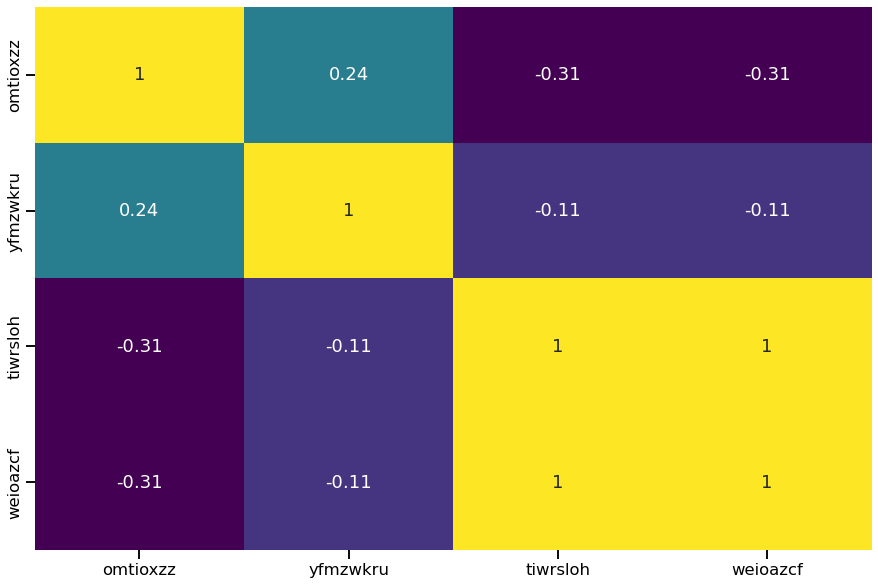

In [10]:
###
# - Checking for collinearity with correlation matrix
###

fig, ax = plt.subplots(1, figsize=(15, 10))
sb.heatmap(train.X_num().corr(), annot = True, cmap = 'viridis', cbar=False, ax=ax)

<AxesSubplot:>

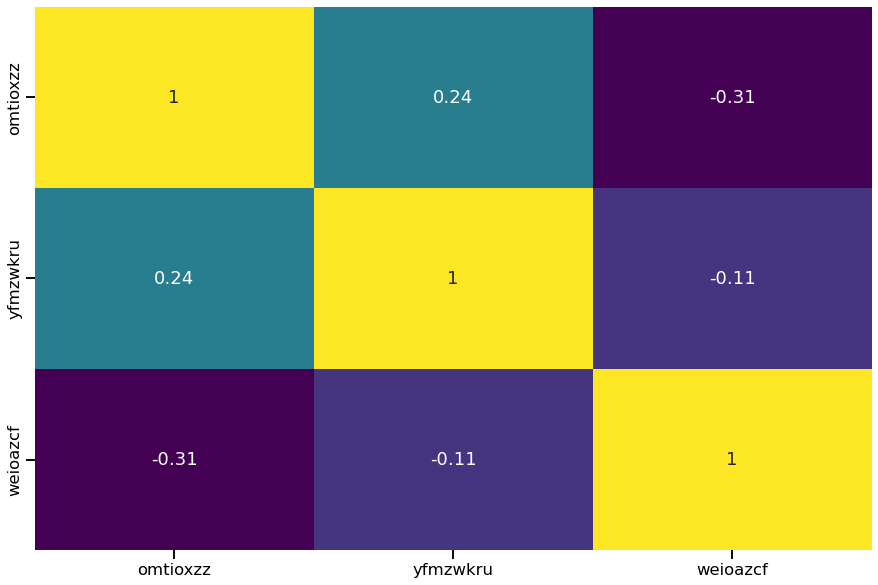

In [11]:
###
# - According correlation matrix the features TIWRSLOH and WEIOAZCF are collinear
# - Let's remove WEIOAZCF from the data since it does not add additional information
# - TIWRSLOH carries the same kind of information
###

other = train._remove_collinearity(['tiwrsloh'])

fig, ax = plt.subplots(1, figsize=(15, 10))
sb.heatmap(other.X_num().corr(), annot = True, cmap = 'viridis', cbar=False, ax=ax)

In [12]:
train = other
train.resume()

DATA FRAME:

     kjkrfgld bpowgknt raksnhjf vwpsxrgk  omtioxzz  yfmzwkru  weioazcf   poor
0       Lsuai    WXYiE    DtMvg    XAmOF      21.0      -2.0     -14.5  False
1       AfgYR    zPfZR    rXCdD    qNABl      12.0      -3.0     -14.5   True
2       KfoTG    zPfZR    DtMvg    NdlDR      21.0      -4.0      -9.5   True
3       Lsuai      NaN    DtMvg    bUhyU      12.0      -3.0       0.5  False
4       Lsuai    THHLT    DtMvg    vVbnO      12.0      -3.0      -4.5  False
...       ...      ...      ...      ...       ...       ...       ...    ...
6557    Lsuai    mDadf    rXCdD    vVbnO      21.0      -3.0      -4.5   True
6558    KfoTG    THHLT      NaN    hmAUm      12.0      -4.0      10.5  False
6559    qzGkS    zPfZR    DtMvg    bUhyU      12.0      -4.0      10.5   True
6560      NaN    WXYiE    TKfyw    bUhyU      30.0      -2.0     -14.5   True
6561    qzGkS    THHLT    rXCdD    QRKWz      12.0      -2.0       0.5  False

[5716 rows x 8 columns]

MISSING VALUES:

   kjkrf

In [13]:
###
# - Let's normalize the numerical features
# - Although the machine learning methods to be used do not 
# - require data normalization, there are others in which 
# - these procedures are very important like in Neural Networks
###

min_X_num = train.X_num().min()
max_X_num = train.X_num().max()
other = train._normalize_numeric(min_X_num, max_X_num) 

In [14]:
train = other
train.resume()

DATA FRAME:

     kjkrfgld bpowgknt raksnhjf vwpsxrgk  omtioxzz  yfmzwkru  weioazcf   poor
0       Lsuai    WXYiE    DtMvg    XAmOF  0.500000       0.4       0.5  False
1       AfgYR    zPfZR    rXCdD    qNABl  0.333333       0.2       0.5   True
2       KfoTG    zPfZR    DtMvg    NdlDR  0.500000       0.0       0.6   True
3       Lsuai      NaN    DtMvg    bUhyU  0.333333       0.2       0.8  False
4       Lsuai    THHLT    DtMvg    vVbnO  0.333333       0.2       0.7  False
...       ...      ...      ...      ...       ...       ...       ...    ...
6557    Lsuai    mDadf    rXCdD    vVbnO  0.500000       0.2       0.7   True
6558    KfoTG    THHLT      NaN    hmAUm  0.333333       0.0       1.0  False
6559    qzGkS    zPfZR    DtMvg    bUhyU  0.333333       0.0       1.0   True
6560      NaN    WXYiE    TKfyw    bUhyU  0.666667       0.4       0.5   True
6561    qzGkS    THHLT    rXCdD    QRKWz  0.333333       0.4       0.8  False

[5716 rows x 8 columns]

MISSING VALUES:

   kjkrf

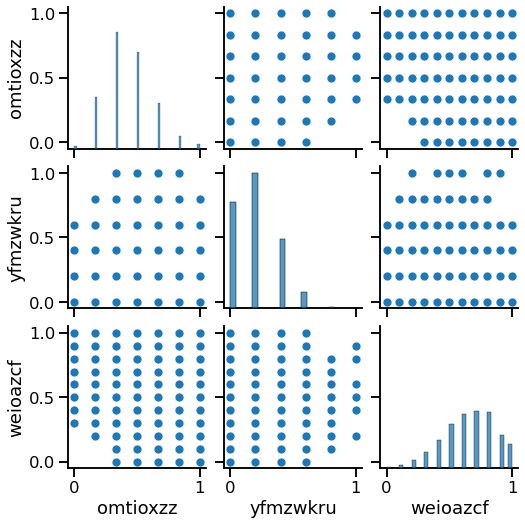

In [15]:
###
# - A final look
###
sb.pairplot(train.X_num())

### COMMENTS
* DATAFRAME
    * the numerical features seem to be ready
    * the categorical features need to be encoded and they still have missing values
    * since we do not want to insert any order, rank, and distance in the encoding process we are going to use the one hot encoding approach (we do not know anything about the categorical data)
	* about the categorical missing values we are not going to discard them since we do not want to lose more data


## CATEGORICAL DATA

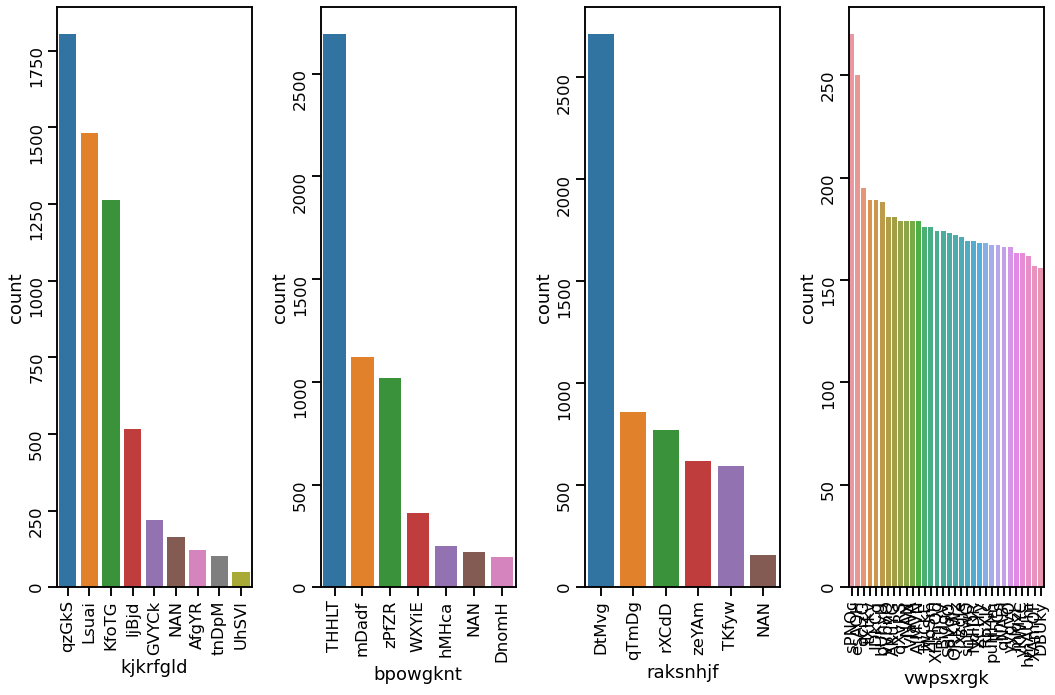

In [16]:
fig, axs = plt.subplots(1,4, figsize=(15, 10))

for enu, col in enumerate(train.X_cat()):
    series = train.df()[col]
    sb.countplot(x=series.fillna('NAN'), order=series.fillna('NAN').value_counts().index, ax=axs[enu])   
    axs[enu].tick_params(labelrotation=90)
fig.tight_layout()

In [17]:
###
# - One hot enconding
# - The amount of missing values is significative with respect of the amount of other categorical data
# - Therefore, we will keep the missing data in the process of one hot encoding
###

other = train._one_hot_encoding()

<AxesSubplot:>

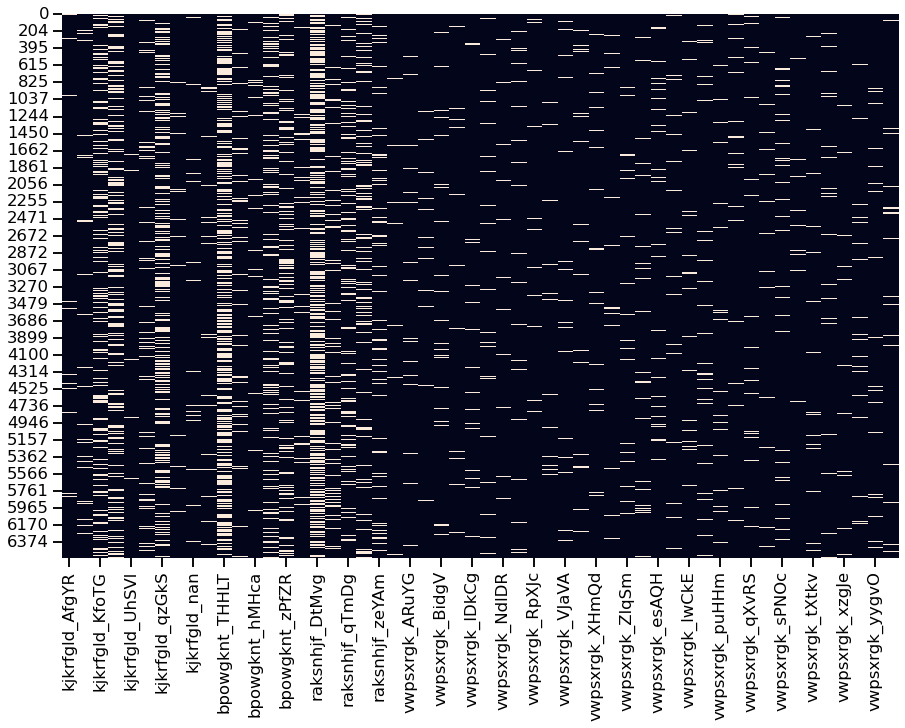

In [18]:
train = other
fig, axs = plt.subplots(1, figsize=(15, 10))
sb.heatmap(train.X_cat(), ax=axs, cbar=False)

In [19]:
train.resume()

DATA FRAME:

      kjkrfgld_AfgYR  kjkrfgld_GVYCk  kjkrfgld_KfoTG  kjkrfgld_Lsuai  \
0                  0               0               0               1   
1                  1               0               0               0   
2                  0               0               1               0   
3                  0               0               0               1   
4                  0               0               0               1   
...              ...             ...             ...             ...   
6557               0               0               0               1   
6558               0               0               1               0   
6559               0               0               0               0   
6560               0               0               0               0   
6561               0               0               0               0   

      kjkrfgld_UhSVl  kjkrfgld_ljBjd  kjkrfgld_qzGkS  kjkrfgld_tnDpM  \
0                  0               0              

### COMMENTS
* Those are the main steps associated with the data exploration and preprocessing processes. Therefore the final shape of the data will look like the one displayed above. 

* We are ready for the training, cross-validation, and testing process. 

* All those steps previously done will be aggregated into a class to help the execution of the next steps

## Label

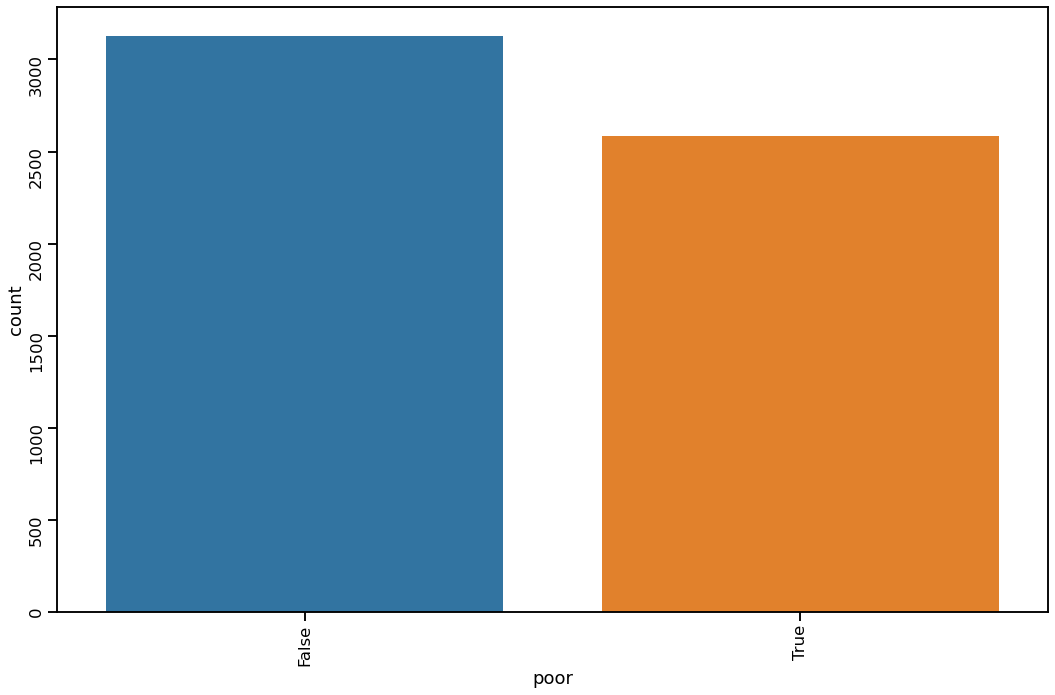

In [20]:
fig, axs = plt.subplots(1,figsize=(15, 10))
series = train.y()
sb.countplot(x=series, ax=axs)   
axs.tick_params(labelrotation=90)
fig.tight_layout()

### COMMENTS
* The data is balanced

# TRAINING AND VALIDATION

In [21]:
class Ensemble:
    """
    Class to hold different models and do prediction with 
    the linear combination of their result
    """
    def __init__(self, models, names, weights):
         self.models = models
         self.names = names
         self.weights = weights
         
    
    def name(self):
        return '{}'.format(list(zip(self.names, self.weights)))
      
         
    def predict_proba(self, X):
        y_prob = np.zeros((len(X), 2, ))
        for weight, clf in zip(self.weights, self.models):
            y_prob += weight*clf.predict_proba(X)
        return y_prob / sum(self.weights)
    
    
    def predict(self, X):
        y_prob = self.predict_proba(X)
        return y_prob[:,1] > 0.5 # Depending of the prediction purposes, this value could be other

In [22]:
class PLPreprocessing:
    """
    Class to guarantee that the same preprocessing procedures 
    are applied to the data (pipeline for preprocessing)
    """
    mean = -1
    std = -1
    min_X_num
    min_X_num
    
    @classmethod
    def procedure_1(cls, train_csv_path, test_csv_path):
        ### TRAINNING DATA ###
        # load data
        train = Xy(train_csv_path)
        
        # removing index features (columns)
        train = train._remove_index_columns(['ID', 'id'])
        
        # removing outliers
        mean = train.X_num().mean(); cls.mean = mean
        std = train.X_num().std(); cls.std = std
        train = train._remove_outliers(3, mean, std)
        
        # removing collinear feature
        train = train._remove_collinearity(['tiwrsloh'])
        
        # normalizing numerical data
        min_X_num = train.X_num().min(); cls.min_X_num = min_X_num
        max_X_num = train.X_num().max(); cls.max_X_num = max_X_num
        train = train._normalize_numeric(min_X_num, max_X_num)        
        
        # one hot encoding categorical data
        train = train._one_hot_encoding()
        
        # just for precaution
        df = train.df()
        train.update(df.dropna())
        
        #train.resume()
        
        
        ### TESTING DATA ###
        # load data
        test = Xy(test_csv_path)
        
        # removing index features (columns)
        test = test._remove_index_columns(['ID', 'id'])
        
        # removing outliers
        # attention, we are using standard deviation information
        # from the training dataset. Therefore any information from
        # the testing dataset is considered and, hence, this should not
        # be considered data leaking
        test = test._remove_outliers(3, mean, std)
        
        # removing collinear feature
        test = test._remove_collinearity(['tiwrsloh'])
        
        # normalizing with information of the training data
        # the same situation as the one from outliers remotion
        test = test._normalize_numeric(min_X_num, max_X_num)  
        
        # one hot encoding categorical data
        test = test._one_hot_encoding()
        
        # just for precaution
        df = test.df()        
        test.update(df.dropna())
        
        return train, test

### COMMENTS
* The two classes in the sequence are related to pertinent operations performed on the selected models. The models selected were: Logistic Regression, Random Forest, AdaBoost, and XGBoost. 

* Logistic Regression: This algorithm is one of the most simple and easy-to-use Machine Learning algorithms for two-class classification. It will be our baseline.

* The other algorithms selected are based on bagging or boosting techniques and all of them are state-of-the-art algorithms in the machine learning context. They work with the ensemble of weak classifiers that together form a strong classifier able to outperform a wide variety of algorithms with the same purpose. 

* Some advantages of those algorithms are:
    * there is no need of data normalization (nevertheless, in the presented data processing workflow we did normalization for the sake of illustration)
    * they are robust to collinearity
    * robust against overfitting
    * robust to outliers

In [23]:
class PLHyperparams:
    """
    Class to help the cross-validation prodecure and the 
    hyperparametrization of the models considered
    """
    @classmethod
    def randomforest(cls, train):    
        criterion_lst = ['gini', 'entropy']        
        n_estimators_lst = [500, 1000, 1500]
        class_weight_lst = [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}]
        
        #criterion_lst = ['gini']        
        #n_estimators_lst = [500]
        #class_weight_lst = [{0:1, 1:1}]
        
        hyper_params_dic = {}
        
        for tup in itertools.product(criterion_lst, n_estimators_lst, class_weight_lst):
            criterion, n_estimators, class_weight = tup
            
            clf = RandomForestClassifier( n_estimators=n_estimators
                                        , criterion=criterion
                                        , class_weight=class_weight
                                        , max_depth=None
                                        , min_samples_split=2
                                        , random_state=0
                                        , n_jobs=4
                                        )
           
            scores = cross_val_score(clf, train.X(), train.y(), cv=5)
            toprint = ''
            toprint += '(estimators, criterion, class_weight)\n\t= ({:04d}, {:7s}, {})'\
                .format(n_estimators, criterion, class_weight)
            toprint += ' | scores\n\t\t= {}'.format(scores)
            toprint += ' | mean_score = {:0.4f}'.format(np.mean(scores))

    
            print(toprint)    
    
            hyper_params_dic[np.mean(scores)] = {
                  'scores': scores
                , 'mean_score': np.mean(scores)
                , 'std_score': np.std(scores)                
                
                }
            hyper_params_dic[np.mean(scores)]['params'] = {
                  'criterion': criterion
                , 'n_estimators': n_estimators
                , 'class_weight': class_weight
                } 
            
        return hyper_params_dic
    
    
    @classmethod
    def adaboost(cls, train):
        learning_rate_lst = [0.75, 1.0, 1.25]    
        n_estimators_lst = [1500, 2000, 2500]
        
        #learning_rate_lst = [1.0]    
        #n_estimators_lst = [500]

        hyper_params_dic = {}
        
        for tup in itertools.product(learning_rate_lst, n_estimators_lst):
            learning_rate, n_estimators = tup
            
            clf = AdaBoostClassifier(  n_estimators=n_estimators
                                     , learning_rate=learning_rate
                                    )
            
            scores = cross_val_score(clf, train.X(), train.y(), cv=5)
            
            toprint = ''
            toprint += '(estimators, learning_rate)\n\t= ({:04d}, {:.2f})'\
                .format(n_estimators, learning_rate)
            toprint += ' | scores\n\t\t= {}'.format(scores)
            toprint += ' | mean_score = {:0.4f}'.format(np.mean(scores))

    
            print(toprint)    
            
            hyper_params_dic[np.mean(scores)] = {
                  'scores': scores
                , 'mean_score': np.mean(scores)
                , 'std_score': np.std(scores)                
                
                }
            hyper_params_dic[np.mean(scores)]['params'] = {
                  'n_estimators': n_estimators
                , 'learning_rate': learning_rate
                } 
 
        return hyper_params_dic

    
    @classmethod
    def logisticregression(cls, train):
        penalty_lst = ['l1', 'l2']
        class_weight_lst = [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}]

        
        hyper_params_dic = {}
        
        for tup in itertools.product(penalty_lst, class_weight_lst):
            penalty, class_weight = tup
            
            clf = LogisticRegression(  penalty=penalty
                                     , class_weight=class_weight
                                     , solver='liblinear' 
                                    )
            
            scores = cross_val_score(clf, train.X(), train.y(), cv=5)
            
            toprint = ''
            toprint += '(penalty, class_weight)\n\t= ({:5s}, {})'\
                .format(penalty, class_weight)
            toprint += ' | scores\n\t\t= {}'.format(scores)
            toprint += ' | mean_score = {:0.4f}'.format(np.mean(scores))

    
            print(toprint)    
            
            hyper_params_dic[np.mean(scores)] = {
                  'scores': scores
                , 'mean_score': np.mean(scores)
                , 'std_score': np.std(scores)                
                
                }
            hyper_params_dic[np.mean(scores)]['params'] = {
                  'penalty': penalty
                , 'class_weight': class_weight
                } 
 
        return hyper_params_dic            
    
    
    @classmethod
    def xgboost(cls, train):
        eta_lst = [0.01, 0.05, 0.1, 0.15, 0.2]
        max_depth_lst = [3, 4, 5, 6]
        gamma_lst = [0, 0.01, 1, 10]
        
        #eta_lst = [0.2]
        #max_depth_lst = [4]
        #gamma_lst = [1]
        
        hyper_params_dic = {}
        
        for tup in itertools.product(eta_lst, max_depth_lst, gamma_lst):
            eta, max_depth, gamma = tup
        
            clf = xgb.XGBClassifier(eval_metric='error', use_label_encoder=False
                                    , eta=eta
                                    , max_depth=max_depth
                                    , gamma=gamma
                                    )

            scores = cross_val_score(clf, train.X(), train.y(), cv=5)
           
            toprint = ''
            toprint += '(eta, max_depth, gamma)\n\t= ({}, {}, {})'\
            .format(eta, max_depth, gamma)
            toprint += ' | scores\n\t\t= {}'.format(scores)
            toprint += ' | mean_score = {:0.4f}'.format(np.mean(scores))

            print(toprint)  
            
            hyper_params_dic[np.mean(scores)] = {
                  'scores': scores
                , 'mean_score': np.mean(scores)
                , 'std_score': np.std(scores)                
                
                }
            hyper_params_dic[np.mean(scores)]['params'] = {
                  'eta': eta
                , 'max_depth': max_depth
                , 'gamma': gamma
                } 
        
        return hyper_params_dic
    
    
    @classmethod
    def ensembleweights(cls, train, models):
        
        names_lst, models_lst = zip(*models.items())        
        
        weights = range(1,6)
        weights_lst =[]
        for _ in range(len(models_lst)):
            weights_lst.append(weights)
            
        y_true_dic = {}
        y_prob_dic = {}        
        weights_dic = {}
        
        for weights in itertools.product(*weights_lst):
            if sum(weights) != 10:
                continue
                
            clf = Ensemble(models_lst, names_lst, weights)                
            name = clf.name()
            
            y_pred = clf.predict(train.X())
            y_prob = clf.predict_proba(test.X()); y_prob_dic[name] = y_prob
            y_true = train.y().to_numpy(); y_true_dic[name] = y_true       
                
            TP = 0; TN = 0
            FP = 0; FN = 0
            for true, pred in zip(y_true, y_pred):
                if pred == 1:
                    if pred == true:
                        TP += 1                        
                    else:
                        FP += 1
                else:
                    if pred == true:
                        TN += 1
                    else:
                        FN += 1            
            
            toprint = ''            
            toprint += '\n{}'.format(name.upper())
            toprint += '\t --> SCORE = {}'.format((TP+TN)/(TP+TN+FP+FN))
            toprint += '\t --> PRECISION = {}'.format(TP/(TP+FP))
            toprint += '\t --> RECALL = {}'.format(TP/(TP+FN))
            toprint += '\n________________________' 
            print(toprint)
            
            precision = TP/(TP+FP)
            recall = TP/(TP+FN)
            myscore = 0.5*precision + 0.5*recall # Depending of the prediction purposes, this value could be other
            weights_dic[myscore] = dict(zip(names_lst, weights))
                
        return weights_dic

In [24]:
class PLModel:
    """
    Class to help training the model with the best hyperparameters
    """
    @classmethod
    def randomforest(cls, train, hyper_params):
        from sklearn.ensemble import RandomForestClassifier
        import numpy as np

        n_estimators = hyper_params['params']['n_estimators']
        criterion = hyper_params['params']['criterion']        
        class_weight = hyper_params['params']['class_weight']
        
        clf = RandomForestClassifier(  n_estimators=n_estimators
                                     , criterion=criterion
                                     , class_weight=class_weight
                                     , max_depth=None
                                     , min_samples_split=2
                                     , random_state=0
                                     , n_jobs=4
                                    )
        
        clf.fit(train.X(), train.y())
        
        return clf
    
    
    @classmethod
    def adaboot(cls, train, hyper_params):
        n_estimators = hyper_params['params']['n_estimators']
        learning_rate = hyper_params['params']['learning_rate']     
        
        clf = AdaBoostClassifier(  n_estimators=n_estimators
                                 , learning_rate=learning_rate
                                )
        
        clf.fit(train.X(), train.y())
        
        return clf
    
    
    @classmethod
    def logisticregression(cls, train, hyper_params):   
        penalty = hyper_params['params']['penalty']
        class_weight = hyper_params['params']['class_weight']
 
        clf = LogisticRegression(  penalty=penalty
                                 , class_weight=class_weight
                                 , solver='liblinear' 
                                )
        
        clf.fit(train.X(), train.y())
        
        return clf
    
    
    @classmethod
    def xgboost(cls, train, hyper_params):        
        eta = hyper_params['params']['eta']
        max_depth = hyper_params['params']['max_depth']
        gamma = hyper_params['params']['gamma']
        
        clf = xgb.XGBClassifier(eval_metric='error', use_label_encoder=False
                        , eta=eta
                        , max_depth=max_depth
                        , gamma=gamma
                        )
        
        clf = xgb.XGBClassifier(eval_metric='error', use_label_encoder=False)

        clf.fit(train.X(), train.y())
  
        return clf

In [25]:
class PLTest:
    @classmethod
    def metrics(cls, test, models):
        y_true_dic = {}
        y_prob_dic = {}
        
        for name in models:
            clf = models[name]
        
            y_pred = clf.predict(test.X())
            y_prob = clf.predict_proba(test.X()); y_prob_dic[name] = y_prob
            y_true = test.y().to_numpy(); y_true_dic[name] = y_true
    
            TP = 0; TN = 0
            FP = 0; FN = 0
            for true, pred in zip(y_true, y_pred):
                if pred == 1:
                    if pred == true:
                        TP += 1                        
                    else:
                        FP += 1
                else:
                    if pred == true:
                        TN += 1
                    else:
                        FN += 1
                        
            toprint = ''            
            toprint += '\n\n{}'.format(name.upper())
            toprint += '\n________________________' 
            toprint += '\n\n{}'.format(clf)
            #toprint += '\n\t --> SCORE     = {}'.format((TP+TN)/(TP+TN+FP+FN))
            #toprint += '\n\t --> PRECISION = {}'.format(TP/(TP+FP))
            #toprint += '\n\t --> RECALL    = {}'.format(TP/(TP+FN))
            print(toprint)            
                        
            target_names = ['rich', 'poor']
            print(classification_report(y_true, y_pred, target_names=target_names))
            
            fig, axs = plt.subplots(1,2,figsize=(15, 5))
            
            fig.suptitle(name.upper())
            
            cm = confusion_matrix(y_true, y_pred)            
            sb.heatmap(cm, annot=True, fmt='d', cbar=False, ax=axs[0])
            axs[0].set_title('Confusion matrix')
            axs[0].set_ylabel('True label')
            axs[0].set_xlabel('Predicted label')
            
            fpr, tpr, thresholds = roc_curve(y_true, y_prob[:,1])
            
            auc = roc_auc_score(y_true, y_prob[:,1])
            
            axs[1].plot(fpr, tpr, label='{} (auc = {:.3f})'.format(name, auc))
            axs[1].set_xlabel('False positive rate')
            axs[1].set_ylabel('True positive rate')
            axs[1].set_title('ROC curve')
            axs[1].legend(loc='best')
            
            print('________________________')
            
        fig, axs = plt.subplots(1,1, figsize=(7.5, 7.5))        
        for key in y_true_dic:
            name = key
            y_true = y_true_dic[name]
            y_prob = y_prob_dic[name]
            fpr, tpr, thresholds = roc_curve(y_true, y_prob[:,1])

            auc = roc_auc_score(y_true, y_prob[:,1])

            axs.plot(fpr, tpr, label='{} (auc = {:.3f})'.format(name, auc))
        axs.set_xlabel('False positive rate')
        axs.set_ylabel('True positive rate')
        axs.set_title('ROC curve')
        axs.legend(loc='best')

## PREPROCESSING

In [26]:
###
# - PROCEDURE 1 preprocessing data involves (it is the unique procedure implemented):
# - -> missing values remotion from numerical features
# - -> remotion of outliers from the numerical features based on 3 times the standard deviation
# - -> remotion of colinear features
# - -> data normalization of the numerical features
# - -> one hot encoding with the maintenance of the missing values
###

train, test = PLPreprocessing.procedure_1('./dataset/Exercise_train (4) (2).csv', './dataset/Exercise_test (4) (2).csv')
models = {}
hyper_params = {}

## LOGISTIC REGRESSION

In [27]:
_hyper_params = PLHyperparams.logisticregression(train)
_hyper_params = _hyper_params[max(_hyper_params.keys())]
_hyper_params 

(penalty, class_weight)
	= (l1   , {0: 1, 1: 1}) | scores
		= [0.74912587 0.76290464 0.76552931 0.7567804  0.74453193] | mean_score = 0.7558
(penalty, class_weight)
	= (l1   , {0: 1, 1: 2}) | scores
		= [0.74737762 0.74453193 0.73228346 0.73228346 0.73490814] | mean_score = 0.7383
(penalty, class_weight)
	= (l1   , {0: 1, 1: 3}) | scores
		= [0.72027972 0.71128609 0.69728784 0.69728784 0.69378828] | mean_score = 0.7040
(penalty, class_weight)
	= (l1   , {0: 1, 1: 4}) | scores
		= [0.68356643 0.67541557 0.67629046 0.67541557 0.66929134] | mean_score = 0.6760
(penalty, class_weight)
	= (l2   , {0: 1, 1: 1}) | scores
		= [0.74825175 0.76290464 0.76465442 0.75765529 0.74365704] | mean_score = 0.7554
(penalty, class_weight)
	= (l2   , {0: 1, 1: 2}) | scores
		= [0.74475524 0.74453193 0.73228346 0.73140857 0.73578303] | mean_score = 0.7378
(penalty, class_weight)
	= (l2   , {0: 1, 1: 3}) | scores
		= [0.71765734 0.70603675 0.6920385  0.69378828 0.69291339] | mean_score = 0.7005
(penalty, cla

{'scores': array([0.74912587, 0.76290464, 0.76552931, 0.7567804 , 0.74453193]),
 'mean_score': 0.7557744311681319,
 'std_score': 0.007970025282102923,
 'params': {'penalty': 'l1', 'class_weight': {0: 1, 1: 1}}}

In [28]:
hyper_params['LogisticRegression'] = _hyper_params    
models['LogisticRegression'] = PLModel.logisticregression(train, _hyper_params)

## RANDOM FOREST 

In [29]:
_hyper_params = PLHyperparams.randomforest(train)
_hyper_params = _hyper_params[max(_hyper_params.keys())]
_hyper_params

(estimators, criterion, class_weight)
	= (0500, gini   , {0: 1, 1: 1}) | scores
		= [0.73951049 0.75240595 0.75765529 0.73665792 0.73490814] | mean_score = 0.7442
(estimators, criterion, class_weight)
	= (0500, gini   , {0: 1, 1: 2}) | scores
		= [0.73601399 0.76027997 0.75590551 0.73228346 0.7384077 ] | mean_score = 0.7446
(estimators, criterion, class_weight)
	= (0500, gini   , {0: 1, 1: 3}) | scores
		= [0.73951049 0.76465442 0.75853018 0.73490814 0.73665792] | mean_score = 0.7469
(estimators, criterion, class_weight)
	= (0500, gini   , {0: 1, 1: 4}) | scores
		= [0.73863636 0.75765529 0.7567804  0.73665792 0.74278215] | mean_score = 0.7465
(estimators, criterion, class_weight)
	= (1000, gini   , {0: 1, 1: 1}) | scores
		= [0.73951049 0.75328084 0.75328084 0.73753281 0.73578303] | mean_score = 0.7439
(estimators, criterion, class_weight)
	= (1000, gini   , {0: 1, 1: 2}) | scores
		= [0.73776224 0.75940507 0.75590551 0.73315836 0.74015748] | mean_score = 0.7453
(estimators, criterion

{'scores': array([0.74388112, 0.75590551, 0.75940507, 0.7384077 , 0.74278215]),
 'mean_score': 0.7480763112652876,
 'std_score': 0.008108601309727046,
 'params': {'criterion': 'entropy',
  'n_estimators': 1000,
  'class_weight': {0: 1, 1: 4}}}

In [30]:
hyper_params['RandomForest'] = _hyper_params    
models['RandomForest'] = PLModel.randomforest(train, _hyper_params)

## ADA BOOST

In [31]:
_hyper_params = PLHyperparams.adaboost(train)
_hyper_params = _hyper_params[max(_hyper_params.keys())]
_hyper_params

(estimators, learning_rate)
	= (1500, 0.75) | scores
		= [0.73776224 0.77952756 0.7664042  0.74628171 0.74978128] | mean_score = 0.7560
(estimators, learning_rate)
	= (2000, 0.75) | scores
		= [0.73776224 0.77952756 0.7664042  0.74628171 0.74978128] | mean_score = 0.7560
(estimators, learning_rate)
	= (2500, 0.75) | scores
		= [0.73776224 0.77952756 0.7664042  0.74628171 0.74978128] | mean_score = 0.7560
(estimators, learning_rate)
	= (1500, 1.00) | scores
		= [0.73776224 0.77952756 0.7664042  0.74628171 0.74978128] | mean_score = 0.7560
(estimators, learning_rate)
	= (2000, 1.00) | scores
		= [0.73776224 0.77952756 0.7664042  0.74628171 0.74978128] | mean_score = 0.7560
(estimators, learning_rate)
	= (2500, 1.00) | scores
		= [0.73776224 0.77952756 0.7664042  0.74628171 0.74978128] | mean_score = 0.7560
(estimators, learning_rate)
	= (1500, 1.25) | scores
		= [0.73776224 0.77952756 0.7664042  0.74628171 0.74978128] | mean_score = 0.7560
(estimators, learning_rate)
	= (2000, 1.25) | sc

{'scores': array([0.73776224, 0.77952756, 0.7664042 , 0.74628171, 0.74978128]),
 'mean_score': 0.7559513976836811,
 'std_score': 0.015016758247702417,
 'params': {'n_estimators': 2500, 'learning_rate': 1.25}}

In [32]:
hyper_params['AdaBoost'] = _hyper_params  
models['AdaBoost'] = PLModel.adaboot(train, _hyper_params)

## XGBOOST

In [33]:
_hyper_params = PLHyperparams.xgboost(train)
_hyper_params = _hyper_params[max(_hyper_params.keys())]
_hyper_params

(eta, max_depth, gamma)
	= (0.01, 3, 0) | scores
		= [0.72115385 0.71216098 0.72790901 0.70603675 0.70778653] | mean_score = 0.7150
(eta, max_depth, gamma)
	= (0.01, 3, 0.01) | scores
		= [0.72115385 0.71216098 0.72790901 0.70603675 0.70778653] | mean_score = 0.7150
(eta, max_depth, gamma)
	= (0.01, 3, 1) | scores
		= [0.72115385 0.71216098 0.72790901 0.70603675 0.70778653] | mean_score = 0.7150
(eta, max_depth, gamma)
	= (0.01, 3, 10) | scores
		= [0.72115385 0.71216098 0.72703412 0.70428696 0.70778653] | mean_score = 0.7145
(eta, max_depth, gamma)
	= (0.01, 4, 0) | scores
		= [0.73688811 0.73053368 0.74890639 0.71216098 0.73140857] | mean_score = 0.7320
(eta, max_depth, gamma)
	= (0.01, 4, 0.01) | scores
		= [0.73688811 0.73053368 0.74890639 0.71216098 0.73140857] | mean_score = 0.7320
(eta, max_depth, gamma)
	= (0.01, 4, 1) | scores
		= [0.73601399 0.72965879 0.74890639 0.71216098 0.73140857] | mean_score = 0.7316
(eta, max_depth, gamma)
	= (0.01, 4, 10) | scores
		= [0.73688811 0.7

(eta, max_depth, gamma)
	= (0.15, 6, 1) | scores
		= [0.74825175 0.76552931 0.77777778 0.75853018 0.75853018] | mean_score = 0.7617
(eta, max_depth, gamma)
	= (0.15, 6, 10) | scores
		= [0.76311189 0.76290464 0.76377953 0.73928259 0.75590551] | mean_score = 0.7570
(eta, max_depth, gamma)
	= (0.2, 3, 0) | scores
		= [0.76660839 0.77427822 0.77252843 0.75940507 0.75415573] | mean_score = 0.7654
(eta, max_depth, gamma)
	= (0.2, 3, 0.01) | scores
		= [0.76660839 0.77427822 0.77252843 0.75940507 0.7480315 ] | mean_score = 0.7642
(eta, max_depth, gamma)
	= (0.2, 3, 1) | scores
		= [0.75786713 0.77077865 0.77165354 0.75590551 0.7664042 ] | mean_score = 0.7645
(eta, max_depth, gamma)
	= (0.2, 3, 10) | scores
		= [0.75699301 0.75590551 0.7664042  0.74365704 0.74978128] | mean_score = 0.7545
(eta, max_depth, gamma)
	= (0.2, 4, 0) | scores
		= [0.7465035  0.77340332 0.76990376 0.76027997 0.76377953] | mean_score = 0.7628
(eta, max_depth, gamma)
	= (0.2, 4, 0.01) | scores
		= [0.75786713 0.7725284

{'scores': array([0.76311189, 0.78040245, 0.77165354, 0.7567804 , 0.76465442]),
 'mean_score': 0.7673205403520365,
 'std_score': 0.008072505616658319,
 'params': {'eta': 0.1, 'max_depth': 5, 'gamma': 1}}

In [34]:
hyper_params['XGBoost'] = _hyper_params  
models['XGBoost'] = PLModel.xgboost(train, _hyper_params)

In [35]:
### ENSEMBLE
_weights = PLHyperparams.ensembleweights(train, models)
_names, _models = zip(*models.items())
weights = []
for _name in _names: 
    weights.append(_weights[max(_weights)][_name])
models['Ensemble'] = Ensemble(_models, _names, weights) 


[('LOGISTICREGRESSION', 1), ('RANDOMFOREST', 1), ('ADABOOST', 3), ('XGBOOST', 5)]	 --> SCORE = 0.8824352694191743	 --> PRECISION = 0.8658256880733946	 --> RECALL = 0.8758700696055685
________________________

[('LOGISTICREGRESSION', 1), ('RANDOMFOREST', 1), ('ADABOOST', 4), ('XGBOOST', 4)]	 --> SCORE = 0.8845346396081175	 --> PRECISION = 0.8672768878718535	 --> RECALL = 0.8793503480278422
________________________

[('LOGISTICREGRESSION', 1), ('RANDOMFOREST', 1), ('ADABOOST', 5), ('XGBOOST', 3)]	 --> SCORE = 0.8880335899230231	 --> PRECISION = 0.8705255140898706	 --> RECALL = 0.8839907192575406
________________________

[('LOGISTICREGRESSION', 1), ('RANDOMFOREST', 2), ('ADABOOST', 2), ('XGBOOST', 5)]	 --> SCORE = 0.9027291812456263	 --> PRECISION = 0.8850531107738998	 --> RECALL = 0.9021655065738592
________________________

[('LOGISTICREGRESSION', 1), ('RANDOMFOREST', 2), ('ADABOOST', 3), ('XGBOOST', 4)]	 --> SCORE = 0.9078026592022393	 --> PRECISION = 0.8909988606152678	 --> RECALL =


[('LOGISTICREGRESSION', 3), ('RANDOMFOREST', 1), ('ADABOOST', 4), ('XGBOOST', 2)]	 --> SCORE = 0.853743876836949	 --> PRECISION = 0.8386222910216719	 --> RECALL = 0.8379737045630317
________________________

[('LOGISTICREGRESSION', 3), ('RANDOMFOREST', 1), ('ADABOOST', 5), ('XGBOOST', 1)]	 --> SCORE = 0.8481455563331001	 --> PRECISION = 0.8319165378670789	 --> RECALL = 0.8325599381283836
________________________

[('LOGISTICREGRESSION', 3), ('RANDOMFOREST', 2), ('ADABOOST', 1), ('XGBOOST', 4)]	 --> SCORE = 0.8840097970608818	 --> PRECISION = 0.8688147295742232	 --> RECALL = 0.8758700696055685
________________________

[('LOGISTICREGRESSION', 3), ('RANDOMFOREST', 2), ('ADABOOST', 2), ('XGBOOST', 3)]	 --> SCORE = 0.885409377186844	 --> PRECISION = 0.8694986605434366	 --> RECALL = 0.8785769528228925
________________________

[('LOGISTICREGRESSION', 3), ('RANDOMFOREST', 2), ('ADABOOST', 3), ('XGBOOST', 2)]	 --> SCORE = 0.8876836948915325	 --> PRECISION = 0.8715596330275229	 --> RECALL = 0

## PERFORMANCE ON TEST DATA



LOGISTICREGRESSION
________________________

LogisticRegression(class_weight={0: 1, 1: 1}, penalty='l1', solver='liblinear')
              precision    recall  f1-score   support

        rich       0.75      0.78      0.76       769
        poor       0.73      0.69      0.71       660

    accuracy                           0.74      1429
   macro avg       0.74      0.74      0.74      1429
weighted avg       0.74      0.74      0.74      1429

________________________


RANDOMFOREST
________________________

RandomForestClassifier(class_weight={0: 1, 1: 4}, criterion='entropy',
                       n_estimators=1000, n_jobs=4, random_state=0)
              precision    recall  f1-score   support

        rich       0.75      0.78      0.77       769
        poor       0.73      0.70      0.72       660

    accuracy                           0.74      1429
   macro avg       0.74      0.74      0.74      1429
weighted avg       0.74      0.74      0.74      1429

______________

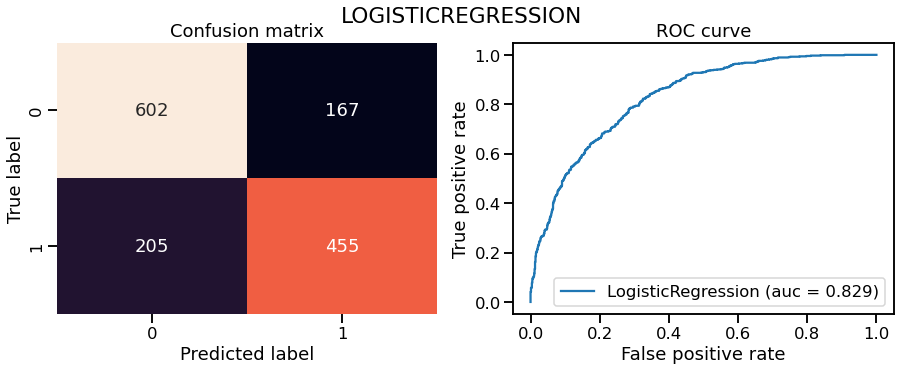

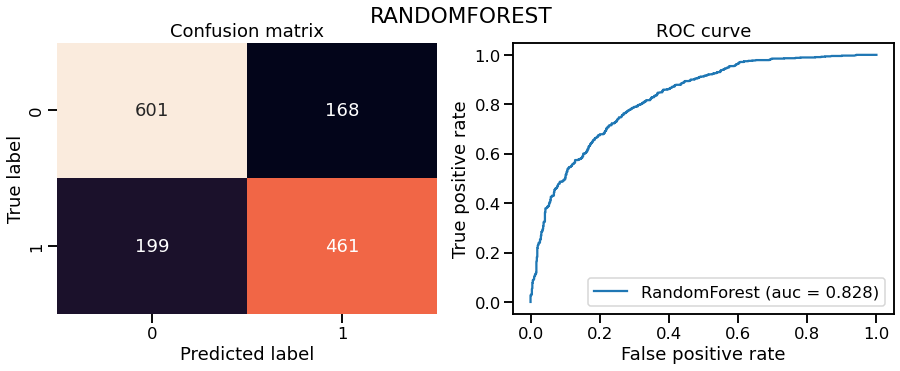

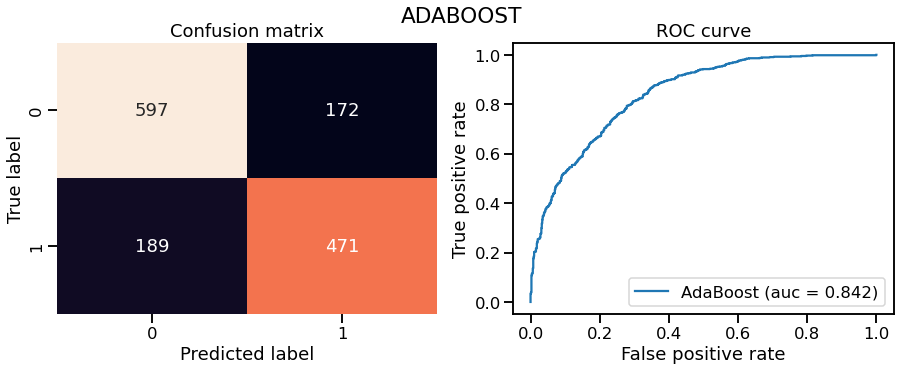

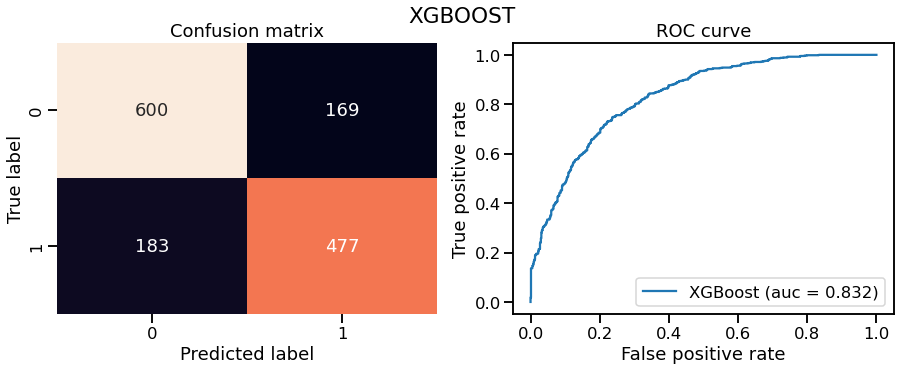

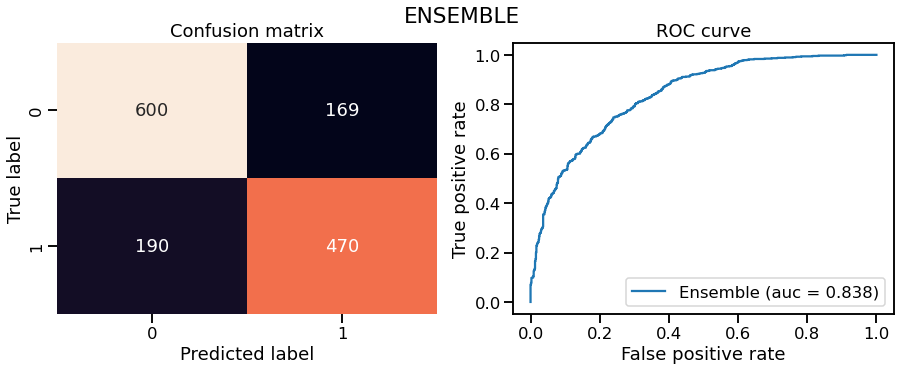

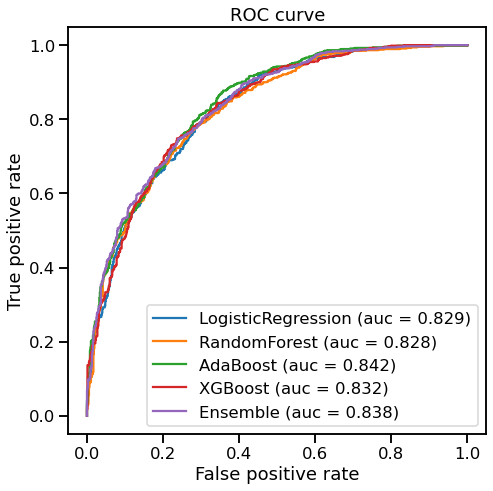

In [36]:
PLTest.metrics(test, models)

### COMMENTS
* From the results presented, all the models had similar performance with the AdaBoost being slightly better than the others. 

* The equivalent performance of the Logistic Regression classifier with the other classifiers used was quite a surprise: I was expecting the ensemble models behavior better than the Logistic Regression (maybe, the parameters, even with the hyper parametrization process, were not well tunned)

* Also, the ensemble of the linear combination of the prediction of all classifiers had an equivalent performance. Since the majority of the models have the same tree structure it is not strange that their linear combination does not improve the final performance of the ensemble classifier. Maybe a Neural Network could be an interest model to do these ensemble.

* Probably, we could improve the performance of the classifiers with the use of more data. Nevertheless, with AdaBoost we were able to reach a score of 0.75 overall accuracy, validating that the data was well treated and the models correctly trained


# PRODUCTION PLAN

### COMMENTS
* Here, we have a really simple scheme on how the models trained could be put in production.

* The ideal is to create a server that would provide the prediction service through an API. Therefore, anyone with the URL could request for the prediction of a country condition poverty when inputting the appropriate data

* Since here is just a proof of concept we did the service in localhost

* In a real case, it would be necessary to externalize the URL and create more endpoints.

In [37]:
###
# - The model with the best performance was AdaBoost. We will select it and put it
# - in the production mode, what means to put into a service
###
production_model = models['AdaBoost']

In [38]:
from flask import Flask, request, jsonify
from threading import Thread
import pandas as pd
app = Flask(__name__)

@app.route('/', methods=['GET', 'POST'])
def hello():
    return 'Hello, World!'

@app.route('/prediction', methods=['POST'])
def prediction():
    json_data = request.get_json()
    
    series = pd.Series(json_data)
    columns = list(series.index)
    values = list(series.values)
    _df = pd.DataFrame([values], columns=columns)
   
    data = Xy()
    data.update(_df)
    
    # removing index features (columns)
    other = data._remove_index_columns(['ID', 'id'])
    
    # removing outliers
    mean = PLPreprocessing.mean
    std = PLPreprocessing.std
    other = other._remove_outliers(3, mean, std)    
   
    # removing collinear feature
    other = other._remove_collinearity(['tiwrsloh'])

    # normalizing numerical data
    min_X_num = PLPreprocessing.min_X_num
    max_X_num = PLPreprocessing.max_X_num
    
    #print(min_X_num)
    #print(max_X_num)
    #print(max_X_num - min_X_num)
    other = other._normalize_numeric(min_X_num, max_X_num) 
    
    # one hot encoding categorical data
    other = other._one_hot_encoding() 
    _df = other.df()
    for column in final_columns:
        if column in _df:
            pass
        else:
            #print(column)
            _df[column] = 0
    poor = _df['poor']
    del _df['poor']
    _df['poor'] = poor
    #print(_df.info())
    other.update(_df)

    #print(other.y())

    #print(other.X())
    pred = production_model.predict(other.X())

    
    return jsonify({'y_pred': 1 if pred[0] else 0})

thr = Thread(target=app.run, kwargs={'host':'localhost', 'port':7777, 'debug':False}, daemon=True)
thr.start()
#app.run(host='localhost', port=7777, debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [39]:
import requests
import time
import pandas as pd
url = 'http://localhost:7777/prediction'

final_columns = train.df().columns

# just getting same data
df = pd.read_csv('./dataset/Exercise_test (4) (2).csv')
df = df.iloc[0:3,:]
#print(df)
df = df.rename(columns={'Unnamed: 0': 'ID'})

for indices, row in df.iterrows():
    pload = row.to_dict(); #print(pload)
    r = requests.post(url=url, json=pload)
    #print()
    time.sleep(2)
    print('y_pred: {}'.format(r.json()['y_pred']), '| y_true: {}'.format(1 if row['poor'] else 0))
    

 * Running on http://localhost:7777/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Dec/2021 22:16:14] "POST /prediction HTTP/1.1" 200 -


y_pred: 1 | y_true: 0


127.0.0.1 - - [19/Dec/2021 22:16:16] "POST /prediction HTTP/1.1" 200 -


y_pred: 1 | y_true: 1


127.0.0.1 - - [19/Dec/2021 22:16:18] "POST /prediction HTTP/1.1" 200 -


y_pred: 1 | y_true: 1
